# Amazon Fine Food Reviews Analysis

Developer  Details : PraveenAI

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [149]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [150]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [151]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [152]:

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [153]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [154]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [155]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [156]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [157]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [158]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [159]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [160]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [161]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[0]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed

In [162]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_1500 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [163]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to 

In [164]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [165]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [166]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [167]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Our dogs just love them I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe 


In [168]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [169]:
# Combining all the above stundents 

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:22<00:00, 2078.72it/s]


In [170]:
print(" size of a Data set" , final['Text'].size , ", length of reviews : ",len(preprocessed_reviews) , " ", final['Text'].size)


 size of a Data set 46071 , length of reviews :  46071   46071


In [171]:
#final['Score'][final['Score']==1] = "Positive"
#final['Score'][final['Score']==0] = "Negative"

In [172]:
#final['Score'][final['Score']==1] = "Positive"
#final['Score'][final['Score']==0] = "Negative"

#final['Score'][final['Score']==1] = "Positive"
#final['Score'][final['Score']==0] = "Negative"

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [173]:
## Similartly you can do preprocessing for review summary also.

### Split the Data 

In [174]:
X = preprocessed_reviews
Y = final['Score']

In [175]:
from sklearn.cross_validation import train_test_split
X_1 , X_test , Y_1 , Y_test  = train_test_split(X,Y,test_size=0.3,random_state=0)
X_tr , X_cv , Y_tr , Y_cv  = train_test_split(X_1,Y_1,test_size=0.3,random_state=0)

We Split the Data for Train, Test and CrossValidation.

Train Data is to Train the Model. Where as Cross validation is to understand the Over/Under fit of a model.

Majorly The Cross Validation will be usefull to figureout the best no of nearest neibhours, It helps the model to Test With.

Test Data is exclusively for testing the trained Model. where we prediect the Outcomes.

# [4] Featurization

## [4.1] BAG OF WORDS

In [176]:
#BoW
count_vect = CountVectorizer(min_df=30, max_features=70) #in scikit-learn  max no of feature in a vector is 300
count_vect.fit(X_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_Bow_Tr = count_vect.transform(X_tr)
X_Bow_Cv = count_vect.transform(X_cv)
X_Bow_Test = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Bow_Tr))
print("the shape of out text BOW vectorizer ",X_Bow_Tr.get_shape())
print("the number of unique words ", X_Bow_Tr.get_shape()[1])

some feature names  ['also', 'amazon', 'bag', 'best', 'better', 'bit', 'bought', 'box', 'buy', 'chocolate']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 70)
the number of unique words  70


In [177]:
X_Bow_Tr = X_Bow_Tr.toarray()
X_Bow_Cv = X_Bow_Cv.toarray()
X_Bow_Test = X_Bow_Test.toarray()

We got the Bag of words vector for each review

Each vectore is of 100 Dimensions.

We have Converted the Train data, Cross Validation Data and the Test to an Identical form, that is Bag Of Words

Also converted the sparse matrixes to dense matrixes

## [4.2] Bi-Grams and n-Grams.

Reduced max_features size,due to computationl issues

## [4.3] TF-IDF

In [178]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30, max_features=70)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_Tfidf_Tr = tf_idf_vect.transform(X_tr)
X_Tfidf_Cv = tf_idf_vect.transform(X_cv)
X_Tfidf_Test = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Tfidf_Tr))
print("the shape of out text TFIDF vectorizer ",X_Tfidf_Tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Tfidf_Tr.get_shape()[1])

some sample features(unique words in the corpus) ['also', 'amazon', 'bag', 'best', 'better', 'bit', 'bought', 'box', 'buy', 'chocolate']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (22574, 70)
the number of unique words including both unigrams and bigrams  70


In [179]:
X_Tfidf_Tr = X_Tfidf_Tr.toarray()
X_Tfidf_Cv = X_Tfidf_Cv.toarray()
X_Tfidf_Test = X_Tfidf_Test.toarray()

We got the TfIdf s vector for each review

Each vectore is of 100 Dimensions.

We have Converted the Train data, Cross Validation Data and the Test to an Identical form, that is TfIdf-vector

Also converted the sparse matrixes to dense matrixes

## [4.4] Word2Vec

In [180]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_tr :
    list_of_sentance.append(sentance.split())

In [181]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=30,size=70, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

We have created the Word2Vec Model with the Training Data Corpus. 

In [182]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 1 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 1 times  3166
sample words  ['favorite', 'nut', 'snacks', 'sunflower', 'absolute', 'almond', 'buttery', 'rich', 'really', 'great', 'given', 'gifts', 'everyone', 'ask', 'buy', 'stay', 'long', 'hours', 'school', 'looking', 'bring', 'not', 'unhealthy', 'found', 'pretty', 'excited', 'since', 'absolutely', 'love', 'full', 'size', 'smaller', 'course', 'much', 'less', 'fruit', 'filling', 'still', 'delicious', 'snack', 'individual', 'bag', 'quite', 'small', 'little', 'hunger', 'helps', 'repeat', 'purchase', 'used']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

# average Word2Vec
# compute average word2vec for each review.

In [183]:
# average Word2Vec
# compute average word2vec for each review.

#def getAvgWordToVector(x):
#    if x < 3:
#        return 0
#    return 1

def getAvgWordToVector(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list    
    for sentence in list_of_sentance: # for each review/sentence
        sent = sentence.split()
        sent_vec = np.zeros(70) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [184]:
X_AvgW2V_Tr     = getAvgWordToVector(X_tr)
X_AvgW2V_Cv     = getAvgWordToVector(X_cv)
X_AvgW2V_Test   = getAvgWordToVector(X_test)

22574
70
9675
70
13822
70


We have created the Average WordtoVec Vectors for each review in the Train Data

#### [4.4.1.2] TFIDF weighted W2v

In [185]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=1, max_features=70) 
tf_idf_matrix = model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [186]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def getAvgW2VtfIdfToVector(list_of_sentance):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sentence in list_of_sentance: # for each review/sentence 
        sent = []
        sent_vec = np.zeros(70) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = sentence.split()
        for word in sent: # for each word in a review/sentence3        
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [187]:
X_AvgW2VtfIdf_Tr     = getAvgW2VtfIdfToVector(X_tr)
X_AvgW2VtfIdf_Cv     = getAvgW2VtfIdfToVector(X_cv)
X_AvgW2VtfIdf_Test   = getAvgW2VtfIdfToVector(X_test)

In [188]:
X_AvgW2VtfIdf_Tr[0]

array([ 0.12421825, -0.96347333,  1.27903725,  1.02377459, -0.07715738,
        0.45785842,  0.00763287, -0.39731525, -1.03407082, -0.23909475,
        0.5594552 , -0.79354915,  0.26635891,  0.58160582,  0.03707935,
       -0.24100805, -0.55271607, -0.04885027,  0.12132413, -0.57295137,
       -0.17638869,  0.25682716,  0.13558562, -0.31369082, -0.36007373,
       -0.45052612,  1.02519157, -0.37695714, -0.6061574 ,  0.22376945,
       -0.81491955, -0.48295462,  0.43720743, -0.70331514, -0.57756556,
       -0.16003028,  0.51863033, -0.9103166 , -0.94457474,  0.05190576,
       -0.01670023,  0.06648053, -0.13083925, -0.82293201,  0.82290824,
        0.5256388 , -0.53291657, -0.39139237, -0.34614278,  0.51781061,
       -0.15311419,  0.06597874,  0.68958409, -0.06948233, -0.15222518,
       -0.77651263, -0.29069334,  1.16683331, -0.54262205, -0.48582012,
       -0.55259421, -0.74967218,  0.07608354, -0.43342726, -0.273494  ,
        0.88578205,  0.6737901 ,  1.56796923, -0.48675159,  0.67

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [189]:
Total_AUC = {}

In [190]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [191]:
neighbors = np.arange(3,32,2)
neighbors

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])

We have taken a list of Odd numbers from 1 to 29 for finding out the best nearest neibhour for each type dataset

The reason behind we chosing the odd numbers is for simplifying the voting process between the classes.


We Split the Data for Train, Test and CrossValidation.

Train Data is to Train the Model. Wherase Cross validation is to understand the Over/Under fit of a model.

Majorly The Cross Validation will be usefull to figureout the best no of nearest neibhours, It helps the model to Test With.

Test Data is exclusively for testing the trained Model. where we prediect the Outcomes.

##### Hyper Parametre Tuning with 20% of Cross Validation Data

In [192]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set1_Acc_Tr    = []
Set1_Acc_Cv    = []
Set1_Train_Auc = []
Set1_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    knn.fit(X_Bow_Tr,Y_tr)   
    
    #pred_tr =  knn.predict(X_Bow_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Bow_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            

    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_Bow_Tr)    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_Bow_Cv)    
    
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob[:,1])
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob[:,1])
      
    Set1_Train_Auc.append(Train_Auc)
    Set1_Cv_Auc.append(Cv_Auc) 

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)

 AUC for the  TRAIN Data at nearest neibour  3  is  0.9074287409914582
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.6740125386996904
 AUC for the  TRAIN Data at nearest neibour  5  is  0.8815581211848615
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.7052143188854489
 AUC for the  TRAIN Data at nearest neibour  7  is  0.863751525333031
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.7185589009287925
 AUC for the  TRAIN Data at nearest neibour  9  is  0.8505493011812338
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.7294779024767801
 AUC for the  TRAIN Data at nearest neibour  11  is  0.8419509317694495
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.7369605650154798
 AUC for the  TRAIN Data at nearest neibour  13  is  0.834457957433172
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.7417635835913312
 AUC for the  TRAIN Data at nearest neibour  15  is  0.8297382682403005
 AUC for the C

Here, we are trianing the KNN-Model with the Bag of words.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We get the  AUC/ROC which helps to judge a Model performance.

Let us see the  AUC values  for Cross Validation Data and Training Data. 

#### Plot AUC Curves for the Train and CrossValidation

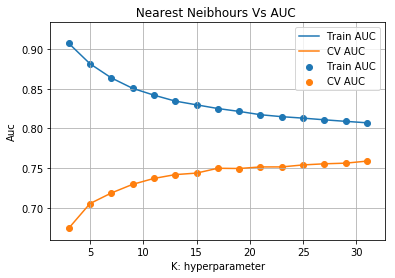

In [193]:
#set1_train_auc,set1_cv_auc
plt.grid()
plt.scatter(neighbors, Set1_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set1_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set1_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set1_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()

AUC for both CrossValidation  and  Training Data Getting Closer/Converging at Neibhour 31

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 31-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the  the Highest AUC.

Average the accruacis from the Hyper parameters, the value we get is the one we expect on top of test data.


In [194]:
print("Train AUC: ",neighbors[Set1_Train_Auc.index(min(Set1_Train_Auc))] )  # Best Fit =  Minimum Errror in Cross Validation Data
print("Cross Validation AUC: ",neighbors[Set1_Cv_Auc.index(max(Set1_Cv_Auc))])         # Best Fit =  MAx Errror in Train Data Set1_Cv_Tr

Train AUC:  31
Cross Validation AUC:  31


In [195]:
Optimal_N = neighbors[Set1_Cv_Auc.index(max(Set1_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )


Highest nearest neighbors of CrosValidation:  31


According to the CrossValidation, we are getting the Highest AUC at Neigherest Neibhour value is at  31.

Hence, we can expext the test data AUc near around the same.

In case we we have the CrossValidation AUC High and Test Accruacy is High, then we can consider it as a Over Fitting.

In case we we have the CrossValidation AUC Low and Test Accruacy is also Low, then we can consider it as a Under Fitting.

In [196]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set1_Train_Pred =  knn.predict(X_Bow_Tr)
#Set1_Train_Acc  = accuracy_score(Y_tr,Set1_Train_Pred,normalize=True)

Set1_Train_Auc = []
Set1_Tst_Auc   = []
Set1_Train_Prb = []
Set1_Tst_Prb   = []
Set1_Train_Predict = []
Set1_Tst_Predict   = []

knn =  KNeighborsClassifier(n_neighbors = Optimal_N, algorithm = 'brute')
knn.fit(X_Bow_Tr,Y_tr)    
Train_Predict =  knn.predict(X_Bow_Tr)
Tst_Predict   =  knn.predict(X_Bow_Test)
        
# Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_Bow_Tr)# Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_Bow_Test)

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob[:,1])
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob[:,1])

#Probablity Scores
Set1_Train_Prb = Train_pred_prob[:,1]
Set1_Tst_Prb=Tst_pred_prob[:,1]

#AUC
Set1_Train_Auc=Train_Auc
Set1_Tst_Auc=Test_Auc
    
#MOdel Predictions    
Set1_Train_Predict=Train_Predict
Set1_Tst_Predict=Tst_Predict   

print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is ", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is ", Test_Auc)

 AUC for the  Train Data at nearest neibour  31  is  0.8070822687202661
 AUC for the Test-Validation Data at nearest neibour  31  is  0.7490356132336193


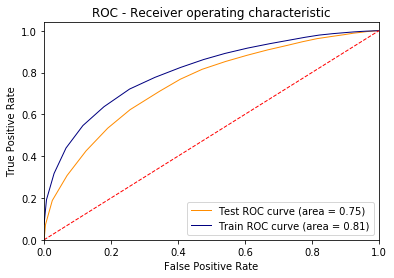

In [197]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set1_tst_fpr, set1_tst_tpr, thresholds = roc_curve(Y_test,Set1_Tst_Prb)
set1_tst_roc_auc = auc(set1_tst_fpr, set1_tst_tpr)


set1_train_fpr, set1_train_tpr, thresholds = roc_curve(Y_tr,Set1_Train_Prb)
set1_train_roc_auc = auc(set1_train_fpr, set1_train_tpr)

lw=1
plt.figure()
plt.plot(set1_tst_fpr, set1_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set1_tst_roc_auc)
plt.plot(set1_train_fpr, set1_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set1_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Test Results of the Model with Neigherest Neibhour value is at 25.
Area Under Curve = "0.66"


In [198]:
Total_AUC['set1']=[Optimal_N , set1_tst_roc_auc]

###### Train Confusion Matrix

Train Confusion Matrix::
 [[  670  3081]
 [  393 18430]] 



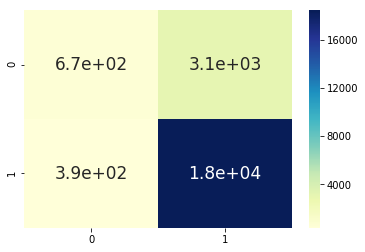

In [199]:
Train_CM= confusion_matrix(Y_tr, Set1_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})

In [200]:
Y_tr.value_counts()

1    18823
0     3751
Name: Score, dtype: int64

###### Test Confusion Matrix

Test Confusion Matrix::
 [[  318  1923]
 [  320 11261]] 



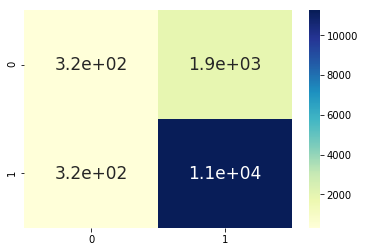

In [201]:
Test_CM= confusion_matrix(Y_test, Set1_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .

Thus in binary classification, the count of 

true negatives is 318 at C(0,0) , 

false negatives is 320 C(1,0), 

true positives is 11261 at C(1,1) 

and false positives is 1923 at C(0,1).



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [202]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set2_Train_Auc = []
Set2_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    knn.fit(X_Tfidf_Tr,Y_tr)    
    
    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set2_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set2_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_Tfidf_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_Tfidf_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set2_Train_Auc.append(Train_Auc)
    Set2_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)

 AUC for the  TRAIN Data at nearest neibour  3  is  0.9074856490836005
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.6587791021671826
 AUC for the  TRAIN Data at nearest neibour  5  is  0.8780214348054
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.6910849845201239
 AUC for the  TRAIN Data at nearest neibour  7  is  0.860786440940299
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.7085582817337461
 AUC for the  TRAIN Data at nearest neibour  9  is  0.8485149431118072
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.7245259287925697
 AUC for the  TRAIN Data at nearest neibour  11  is  0.8385591358286677
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.7294190015479877
 AUC for the  TRAIN Data at nearest neibour  13  is  0.8303952536101763
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.7362797213622292
 AUC for the  TRAIN Data at nearest neibour  15  is  0.8266847482758072
 AUC for the Cro

Here, we are trianing the KNN-Model with the Bag of words.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the AUC, Error and AUC/ROC which helps to judge a Model performance.

Let us see the  AUC values for Cross Validation Data and Training Data at each k.

#### AUC Curves for the Train and CrossValidation Data

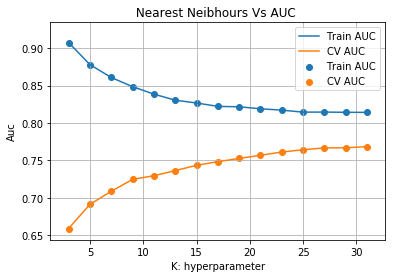

In [203]:
#set2_train_auc,set2_cv_auc
plt.grid()
plt.scatter(neighbors, Set2_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set2_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set2_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set2_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()

Both AUC for CrossValidation  and  Training Data Getting Closer/Converging at Neibhour 31

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 19-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the  the Highest AUC.

Average the accruacis from the Hyper parameters, the value we get is the one we expect on top of test data.



In [204]:
Optimal_N = neighbors[Set2_Cv_Auc.index(max(Set2_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )


Highest nearest neighbors of CrosValidation:  31



According to the CrossValidation, we are getting the Highest AUC at Neigherest Neibhour value is at 31.

Hence, we can expext the test data AUC near around the same.

In case  we have the CrossValidation AUC High and Test AUC is High, then we can consider it as a Over Fitting.

In case we have the CrossValidation AUC Low and Test AUc is also Low, then we can consider it as a Under Fitting.

In [205]:

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set2_Train_Pred =  knn.predict(X_Bow_Tr)
#Set2_Train_Acc  = accuracy_score(Y_tr,Set2_Train_Pred,normalize=True)

Set2_Train_Auc = []
Set2_Tst_Auc   = []
Set2_Train_Prb = []
Set2_Tst_Prb   = []
Set2_Train_Predict = []
Set2_Tst_Predict   = []

knn =  KNeighborsClassifier(n_neighbors = Optimal_N, algorithm = 'brute')
knn.fit(X_Tfidf_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_Tfidf_Tr)
Tst_Predict   =  knn.predict(X_Tfidf_Test)
        
# Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_Tfidf_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_Tfidf_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

#Probablity Scores
Set2_Train_Prb = Train_pred_prob
Set2_Tst_Prb =Tst_pred_prob 
    
#AUC
Set2_Train_Auc= Train_Auc
Set2_Tst_Auc=Test_Auc
    
#MOdel Predictions    
Set2_Train_Predict = Train_Predict
Set2_Tst_Predict = Tst_Predict


print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is ", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is ", Test_Auc)

 AUC for the  Train Data at nearest neibour  31  is  0.8141215008728906
 AUC for the Test-Validation Data at nearest neibour  31  is  0.7525841018662144


###### AUC and ROC for Knn-bruteforce on top BagOfWords

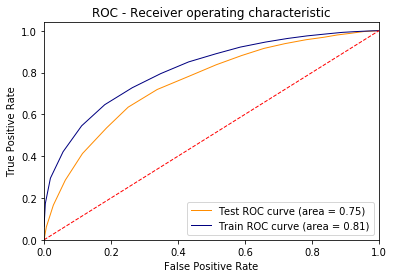

In [206]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set2_tst_fpr, set2_tst_tpr, thresholds = roc_curve(Y_test,Tst_pred_prob)
set2_tst_roc_auc = auc(set2_tst_fpr, set2_tst_tpr)


set2_train_fpr, set2_train_tpr, thresholds = roc_curve(Y_tr,Train_pred_prob)
set2_train_roc_auc = auc(set2_train_fpr, set2_train_tpr)

lw=1
plt.figure()
plt.plot(set2_tst_fpr, set2_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set2_tst_roc_auc)
plt.plot(set2_train_fpr, set2_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set2_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Test Results of the Model with Neigherest Neibhour value is at 31.

Auc is = "0.72"


In [207]:
Total_AUC['set2']=[Optimal_N , set2_tst_roc_auc]

#### Train Confusion Matrix

Train Confusion Matrix::
 [[  412  3339]
 [  150 18673]] 



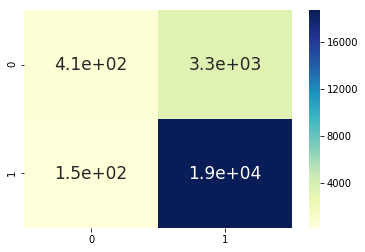

In [208]:

Train_CM= confusion_matrix(Y_tr, Set2_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


#### Test Confusion Matrix

Test Confusion Matrix::
 [[  189  2052]
 [  143 11438]] 



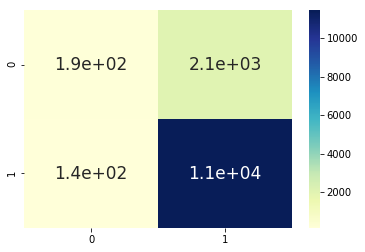

In [209]:
Test_CM= confusion_matrix(Y_test, Set2_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .

Thus in binary classification, the count of 

true negatives is 189 at C(0,0) , 

false negatives is 143 C(1,0), 

true positives is 11438 at C(1,1) 

and false positives is 2052 at C(0,1).


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [210]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set3_Train_Auc = []
Set3_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    knn.fit(X_AvgW2V_Tr,Y_tr)    
    
    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set3_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set3_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_AvgW2V_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_AvgW2V_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set3_Train_Auc.append(Train_Auc)
    Set3_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)
    

 AUC for the  TRAIN Data at nearest neibour  3  is  0.9538551146317772
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.7705941950464397
 AUC for the  TRAIN Data at nearest neibour  5  is  0.9349450711565725
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.8086689628482973
 AUC for the  TRAIN Data at nearest neibour  7  is  0.9237257852562522
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.8247266253869969
 AUC for the  TRAIN Data at nearest neibour  9  is  0.9158371240548111
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.8348497678018576
 AUC for the  TRAIN Data at nearest neibour  11  is  0.9113497906871366
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.8443977554179568
 AUC for the  TRAIN Data at nearest neibour  13  is  0.9089620302495828
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.8510549148606811
 AUC for the  TRAIN Data at nearest neibour  15  is  0.9060312635042527
 AUC for the

#### Plot AUC Curves for the Train and CrossValidation

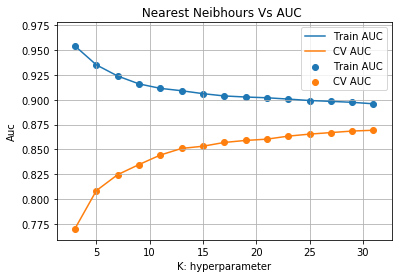

In [211]:
#set3_train_auc,set3_cv_auc
plt.grid()
plt.scatter(neighbors, Set3_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set3_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set3_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set3_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()


Here, we are trianing the KNN-Model with the Average Woork2Vec.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the AUC, Error and AUC/ROC which helps to judge a Model performance.

Let us see the  AUC values for Cross Validation Data and Training Data at each k.




In [212]:
Optimal_N = neighbors[Set3_Cv_Auc.index(max(Set3_Cv_Auc))]  
print("Best nearest neighbors of CrosValidation: ", Optimal_N  )

Best nearest neighbors of CrosValidation:  31



According to the CrossValidation, we are getting the Highest AUC at Neigherest Neibhour value is at 31.

Hence, we can expext the test data AUC near around the same.

In case  we have the CrossValidation AUC High and Test AUC is High, then we can consider it as a Over Fitting.

In case we have the CrossValidation AUC Low and Test AUc is also Low, then we can consider it as a Under Fitting.

In [213]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set3_Train_Pred =  knn.predict(X_Bow_Tr)
#Set3_Train_Acc  = accuracy_score(Y_tr,Set3_Train_Pred,normalize=True)

Set3_Train_Auc = []
Set3_Tst_Auc   = []
Set3_Train_Prb = []
Set3_Tst_Prb   = []
Set3_Train_Predict = []
Set3_Tst_Predict   = []


knn =  KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
knn.fit(X_AvgW2V_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_AvgW2V_Tr)
Tst_Predict   =  knn.predict(X_AvgW2V_Test)
        
# Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_AvgW2V_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_AvgW2V_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

#Probablity Scores
Set3_Train_Prb = Train_pred_prob
Set3_Tst_Prb = Tst_pred_prob
    
#AUC
Set3_Train_Auc= Train_Auc
Set3_Tst_Auc = Test_Auc
    
#MOdel Predictions    
Set3_Train_Predict= Train_Predict
Set3_Tst_Predict=Tst_Predict


print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is ", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is ", Test_Auc)

 AUC for the  Train Data at nearest neibour  31  is  0.8958472148311497
 AUC for the Test-Validation Data at nearest neibour  31  is  0.8591701520990562


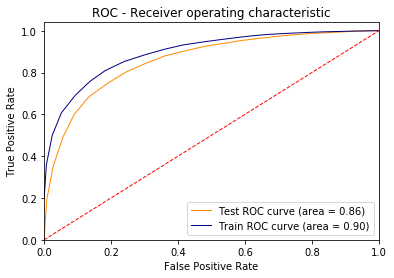

In [214]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set3_tst_fpr, set3_tst_tpr, thresholds = roc_curve(Y_test,Set3_Tst_Prb)
set3_tst_roc_auc = auc(set3_tst_fpr, set3_tst_tpr)


set3_train_fpr, set3_train_tpr, thresholds = roc_curve(Y_tr,Set3_Train_Prb)
set3_train_roc_auc = auc(set3_train_fpr, set3_train_tpr)

lw=1
plt.figure()
plt.plot(set3_tst_fpr, set3_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set3_tst_roc_auc)
plt.plot(set3_train_fpr, set3_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set3_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [215]:
Total_AUC['set3']=[Optimal_N , set3_tst_roc_auc]

###### Confusion Matrix

Train Confusion Matrix::
 [[ 1237  2514]
 [  334 18489]] 



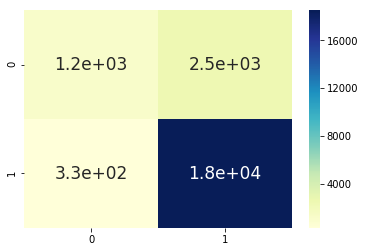

In [216]:
Train_CM= confusion_matrix(Y_tr, Set3_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})

Test Confusion Matrix::
 [[  628  1613]
 [  265 11316]] 



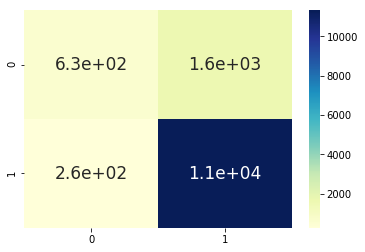

In [217]:
Test_CM= confusion_matrix(Y_test, Set3_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .


Horizantal Lines are Predictions and the Verticals are Acutuals
 

Thus in binary classification, the count of 

true negatives is 628 at C(0,0) , 

false negatives is 265 C(1,0), 

true positives is 11316 at C(1,1) 

and false positives is 1613 at C(0,1).


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [218]:
# Please write all the code with proper documentation
#Bag_O_W_Dense,Tfidf_Data_Dense,Total_W2V_Vecors,Tfidf_W2V_vectors

In [219]:

#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set4_Train_Auc = []
Set4_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    knn.fit(X_AvgW2VtfIdf_Tr,Y_tr)    
    
    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set4_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set4_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_AvgW2VtfIdf_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_AvgW2VtfIdf_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set4_Train_Auc.append(Train_Auc)
    Set4_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)

 AUC for the  TRAIN Data at nearest neibour  3  is  0.9134352144923071
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.6609238777089783
 AUC for the  TRAIN Data at nearest neibour  5  is  0.8806625906328289
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.6824257352941177
 AUC for the  TRAIN Data at nearest neibour  7  is  0.8626597270142331
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.6991528250773995
 AUC for the  TRAIN Data at nearest neibour  9  is  0.8489262237573213
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.7088974845201239
 AUC for the  TRAIN Data at nearest neibour  11  is  0.8378836107144879
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.7187628095975231
 AUC for the  TRAIN Data at nearest neibour  13  is  0.8330921490584678
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.724004721362229
 AUC for the  TRAIN Data at nearest neibour  15  is  0.8276535384362538
 AUC for the 

Here, we are trianing the KNN-Model with the Tf-Idf values.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the  Error and AUC/ROC which helps to judge a Model performance.

Let us see the  AUC values for Cross Validation Data and Training Data.

#### AUC Vs KNN  -  for the Train and CrossValidation Data

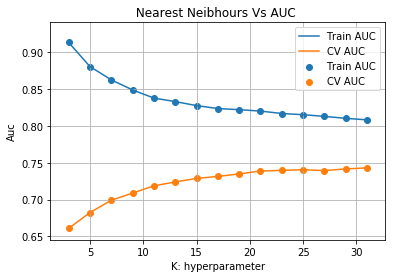

In [220]:
#set4_train_auc,set4_cv_auc
plt.grid()
plt.scatter(neighbors, Set4_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set4_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set4_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set4_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()


AUC for Both CrossValidation  and  Training Data Getting Closer/Converging at Neibhour 9 

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 9-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the  the Highest AUC
.

Average the AUc from the Hyper parameters, the value we get is the one we expect on top of test data.


In [221]:
Optimal_N = neighbors[Set4_Cv_Auc.index(max(Set4_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )

Highest nearest neighbors of CrosValidation:  31



Nearest Neibhours we have at highest AUC is = 31

Hence, we can expect the test data AUC near around the same.

In case we we have the CrossValidation AUC High and Test AUC is High, then we can consider it as a Over Fitting.

In case we we have the CrossValidation AUC Low and Test AUC is also Low, then we can consider it as a Under Fitting


In [ ]:

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set4_Train_Pred =  knn.predict(X_Bow_Tr)
#Set4_Train_Acc  = accuracy_score(Y_tr,Set4_Train_Pred,normalize=True)

Set4_Train_Auc = []
Set4_Tst_Auc   = []
Set4_Train_Prb = []
Set4_Tst_Prb   = []
Set4_Train_Predict = []
Set4_Tst_Predict   = []


knn =  KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
knn.fit(X_AvgW2VtfIdf_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_AvgW2VtfIdf_Tr)
Tst_Predict   =  knn.predict(X_AvgW2VtfIdf_Test)
        
   # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_AvgW2VtfIdf_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_AvgW2VtfIdf_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

    #Probablity Scores
Set4_Train_Prb=Train_pred_prob
Set4_Tst_Prb=Tst_pred_prob
    
    #AUC
Set4_Train_Auc=Train_Auc
Set4_Tst_Auc=Test_Auc
    
    #MOdel Predictions    
Set4_Train_Predict=Train_Predict
Set4_Tst_Predict=Tst_Predict

print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is ", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is ", Test_Auc)

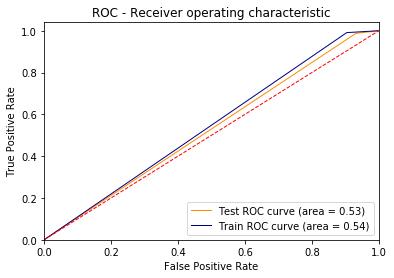

In [223]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set4_tst_fpr, set4_tst_tpr, thresholds = roc_curve(Y_test,Set4_Tst_Predict)
set4_tst_roc_auc = auc(set4_tst_fpr, set4_tst_tpr)


set4_train_fpr, set4_train_tpr, thresholds = roc_curve(Y_tr,Set4_Train_Predict)
set4_train_roc_auc = auc(set4_train_fpr, set4_train_tpr)

lw=1
plt.figure()
plt.plot(set4_tst_fpr, set4_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set4_tst_roc_auc)
plt.plot(set4_train_fpr, set4_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set4_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [224]:
Total_AUC['set4']=[Optimal_N , set4_tst_roc_auc]

###### Confusion Matrix

Train Confusion Matrix::
 [[  360  3391]
 [  170 18653]] 



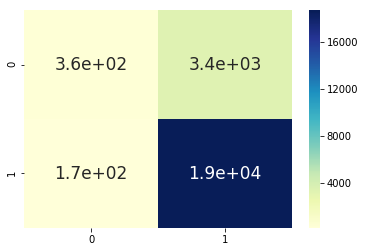

In [225]:
Train_CM= confusion_matrix(Y_tr, Set4_Train_Predict, labels=None, sample_weight=None)   
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})

Test Confusion Matrix::
 [[  154  2087]
 [  147 11434]] 



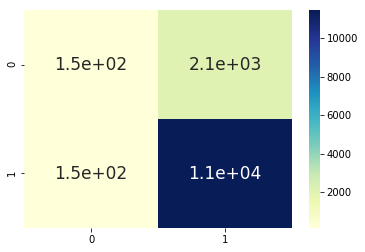

In [226]:
Test_CM= confusion_matrix(Y_test, Set4_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .


Horizantal Lines are Predictions and the Verticals are Acutuals
 

Thus in binary classification, the count of 

true negatives is 154 at C(0,0) , 

false negatives is 147 C(1,0), 

true positives is 11434 at C(1,1) 

and false positives is 2087 at C(0,1).


In [227]:
# Please write all the code with proper documentation

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [228]:
# Please write all the code with proper documentation

In [229]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set5_Train_Auc = []
Set5_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i,leaf_size=30 , algorithm= 'kd_tree')
    knn.fit(X_Bow_Tr,Y_tr)    

    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set5_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set5_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_Bow_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_Bow_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set5_Train_Auc.append(Train_Auc)
    Set5_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)


 AUC for the  TRAIN Data at nearest neibour  3  is  0.9075206111606173
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.6729682275541796
 AUC for the  TRAIN Data at nearest neibour  5  is  0.8759118838387151
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.6979592492260062
 AUC for the  TRAIN Data at nearest neibour  7  is  0.856668330333714
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.7148040247678018
 AUC for the  TRAIN Data at nearest neibour  9  is  0.8477760160378278
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.7237731037151702
 AUC for the  TRAIN Data at nearest neibour  11  is  0.837892221993737
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.7308560758513931
 AUC for the  TRAIN Data at nearest neibour  13  is  0.8335559825849908
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.7415518962848298
 AUC for the  TRAIN Data at nearest neibour  15  is  0.8284478298039575
 AUC for the C

Here, we are trianing the KD-Tree Model with the Bag of words values.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the AUC/ROC which helps to judge a Model performance.

Let us see the AUC values for Cross Validation Data and Training Data

#### Plot KNN VS AUC

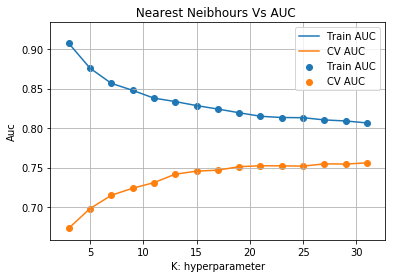

In [230]:
#set5_train_auc,set5_cv_auc
plt.grid()
plt.scatter(neighbors, Set5_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set5_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set5_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set5_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()

Both AUC for CrossValidation  and  Training Data Getting Closer/Converging at Neibhour 23 

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 23-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the  the Highest accuracy.

Average the accruacis from the Hyper parameters, the value we get is the one we expect on top of test data.


In [231]:
#set1_tst_fpr, set1_tst_tpr, set1_tst_thresholds = roc_curve(set1_tst_pred, Y_test)
#set1_cv_roc_auc = auc(set1_tst_fpr, set1_tst_fpr)

#https://qiita.com/bmj0114/items/460424c110a8ce22d945

Optimal_N = neighbors[Set5_Cv_Auc.index(max(Set5_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )

Highest nearest neighbors of CrosValidation:  31




Hence, we can expext the test data AUC near around the same.

In case we we have the CrossValidation AUC High and Test Accruacy is High, then we can consider it as a Over Fitting.

In case we we have the CrossValidation AUC Low and Test Accruacy is also Low, then we can consider it as a Under Fitting

In [232]:

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set5_Train_Pred =  knn.predict(X_Bow_Tr)
#Set5_Train_Acc  = accuracy_score(Y_tr,Set5_Train_Pred,normalize=True)

Set5_Train_Auc = []
Set5_Tst_Auc   = []
Set5_Train_Prb = []
Set5_Tst_Prb   = []
Set5_Train_Predict = []
Set5_Tst_Predict   = []

knn =  KNeighborsClassifier(n_neighbors = i,leaf_size=30 , algorithm= 'kd_tree')
knn.fit(X_Bow_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_Bow_Tr)
Tst_Predict   =  knn.predict(X_Bow_Test)
        
# Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_Bow_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_Bow_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

    #Probablity Scores
Set5_Train_Prb = Train_pred_prob
Set5_Tst_Prb = Tst_pred_prob
    
    #AUC
Set5_Train_Auc=Train_Auc
Set5_Tst_Auc=Test_Auc
    
    #MOdel Predictions    
Set5_Train_Predict=Train_Predict
Set5_Tst_Predict=Tst_Predict

print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is \n", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is \n", Test_Auc)

 AUC for the  Train Data at nearest neibour  31  is 
 0.8064759666773519
 AUC for the Test-Validation Data at nearest neibour  31  is 
 0.745163983029182


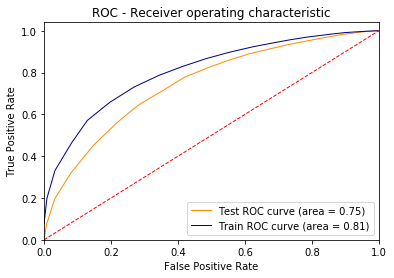

In [233]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set5_tst_fpr, set5_tst_tpr, thresholds = roc_curve(Y_test,Set5_Tst_Prb)
set5_tst_roc_auc = auc(set5_tst_fpr, set5_tst_tpr)


set5_train_fpr, set5_train_tpr, thresholds = roc_curve(Y_tr,Set5_Train_Prb)
set5_train_roc_auc = auc(set5_train_fpr, set5_train_tpr)

lw=1
plt.figure()
plt.plot(set5_tst_fpr, set5_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set5_tst_roc_auc)
plt.plot(set5_train_fpr, set5_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set5_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [234]:
Total_AUC['set5']=[Optimal_N , set5_tst_roc_auc]

###### Confusion Matrix

Train Confusion Matrix::
 [[  621  3130]
 [  391 18432]] 



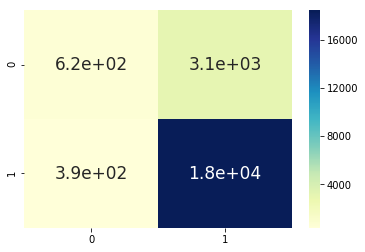

In [235]:
Train_CM= confusion_matrix(Y_tr, Set5_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})

Test Confusion Matrix::
 [[  293  1948]
 [  277 11304]] 



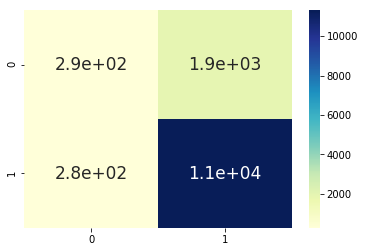

In [236]:
Test_CM= confusion_matrix(Y_test, Set5_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .


Horizantal Lines are Predictions and the Verticals are Acutuals
 

Thus in binary classification, the count of 

true negatives is 293 at C(0,0) , 

false negatives is 277 C(1,0), 

true positives is 11304 at C(1,1),

and false positives is 1948 at C(0,1).


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [237]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set6_Train_Auc = []
Set6_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, leaf_size=30 , algorithm= 'kd_tree')
    knn.fit(X_Tfidf_Tr,Y_tr)    
    
    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set6_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set6_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_Tfidf_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_Tfidf_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set6_Train_Auc.append(Train_Auc)
    Set6_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)    

 AUC for the  TRAIN Data at nearest neibour  3  is  0.907740892782591
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.6590726393188855
 AUC for the  TRAIN Data at nearest neibour  5  is  0.8764307771482652
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.6862049922600618
 AUC for the  TRAIN Data at nearest neibour  7  is  0.8600517203629263
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.7065621517027864
 AUC for the  TRAIN Data at nearest neibour  9  is  0.8497561287133009
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.7232135061919505
 AUC for the  TRAIN Data at nearest neibour  11  is  0.8392996279459977
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.7291846749226006
 AUC for the  TRAIN Data at nearest neibour  13  is  0.8316465730444043
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.734661145510836
 AUC for the  TRAIN Data at nearest neibour  15  is  0.8278961059922706
 AUC for the C

Here, we are trianing the KD-Tree Model with the Tf-Idf values.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the AUC , Error and AUC/ROC which helps to judge a Model performance.

Let us see the AUC values for Cross Validation Data and Training Data.

#### Plot K-NN Vs AUC

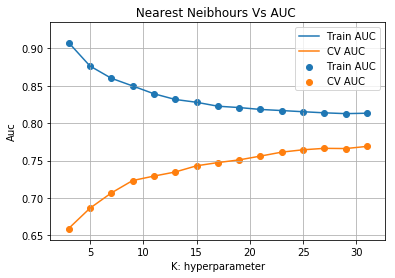

In [238]:
#set6_train_auc,set6_cv_auc
plt.grid()
plt.scatter(neighbors, Set6_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set6_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set6_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set6_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()

Both  AUC  for CrossValidation  and  Training Data Getting Closer/Converging at Neibhour 25 

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 25-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the  the Highest accuracy.

Average the accruacis from the Hyper parameters, the value we get is the one we expect on top of test data.


In [239]:
Optimal_N = neighbors[Set6_Cv_Auc.index(max(Set6_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )

Highest nearest neighbors of CrosValidation:  31


According to the CrossValidation, we are getting the Highest Accuacy at Neigherest Neibhour value is at 31.

In case we we have the CrossValidation AUC  High and Test Accruacy is High, then we can consider it as a Over Fitting.

In case we we have the CrossValidation AUC Low and Test Accruacy is also Low, then we can consider it as a Under Fitting


In [240]:

Hence, we can expext the test data Accuracy near around the same.
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set6_Train_Pred =  knn.predict(X_Bow_Tr)
#Set6_Train_Acc  = accuracy_score(Y_tr,Set6_Train_Pred,normalize=True)

Set6_Train_Auc = []
Set6_Tst_Auc   = []
Set6_Train_Prb = []
Set6_Tst_Prb   = []
Set6_Train_Predict = []
Set6_Tst_Predict   = []


knn =  KNeighborsClassifier(n_neighbors = i, leaf_size=30 , algorithm= 'kd_tree')
knn.fit(X_Tfidf_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_Tfidf_Tr)
Tst_Predict   =  knn.predict(X_Tfidf_Test)
        
# Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_Tfidf_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_Tfidf_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

    #Probablity Scores
Set6_Train_Prb=Train_pred_prob
Set6_Tst_Prb=Tst_pred_prob
    
    #AUC
Set6_Train_Auc=Train_Auc
Set6_Tst_Auc=Test_Auc
    
    #MOdel Predictions    
Set6_Train_Predict=Train_Predict
Set6_Tst_Predict=Tst_Predict


print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is \n", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is \n", Test_Auc)

 AUC for the  Train Data at nearest neibour  31  is 
 0.8132762004225956
 AUC for the Test-Validation Data at nearest neibour  31  is 
 0.7518026128827161


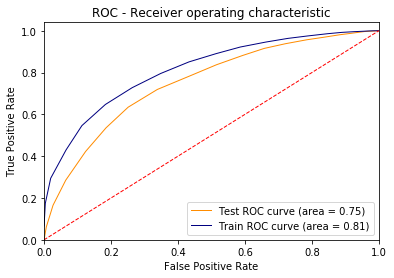

In [241]:

#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set6_tst_fpr, set6_tst_tpr, thresholds = roc_curve(Y_test,Set6_Tst_Prb)
set6_tst_roc_auc = auc(set6_tst_fpr, set6_tst_tpr)


set6_train_fpr, set6_train_tpr, thresholds = roc_curve(Y_tr,Set6_Train_Prb)
set6_train_roc_auc = auc(set6_train_fpr, set6_train_tpr)

lw=1
plt.figure()
plt.plot(set6_tst_fpr, set6_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set6_tst_roc_auc)
plt.plot(set6_train_fpr, set6_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set6_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [242]:
Total_AUC['set6']=[Optimal_N , set6_tst_roc_auc]

###### Train Confusion Matrix

Train Confusion Matrix::
 [[  416  3335]
 [  150 18673]] 



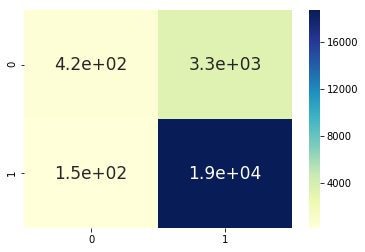

In [243]:
Train_CM= confusion_matrix(Y_tr, Set6_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})

#### Test Confusion Matrix

Test Confusion Matrix::
 [[  187  2054]
 [  145 11436]] 



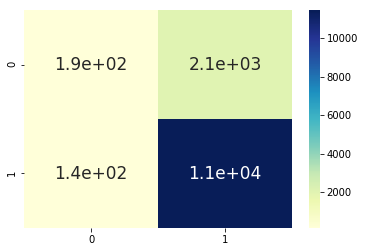

In [244]:
Test_CM= confusion_matrix(Y_test, Set6_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})



By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .


Horizantal Lines are Predictions and the Verticals are Acutuals
 

Thus in binary classification, the count of 

true negatives is 187 at C(0,0) ,

false negatives is 145 C(1,0),

true positives is 11436 at C(1,1)

false positives is 2054 at C(0,1).

Accuracy : 0.8632153882688198

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

In [245]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set7_Train_Auc = []
Set7_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, leaf_size=30 , algorithm= 'kd_tree')
    knn.fit(X_AvgW2V_Tr,Y_tr)    
    
    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set7_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set7_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_AvgW2V_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_AvgW2V_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set7_Train_Auc.append(Train_Auc)
    Set7_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)
    

 AUC for the  TRAIN Data at nearest neibour  3  is  0.9538099195790082
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.7716401702786377
 AUC for the  TRAIN Data at nearest neibour  5  is  0.9349450711565725
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.8086689628482973
 AUC for the  TRAIN Data at nearest neibour  7  is  0.9237257852562522
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.8247266253869969
 AUC for the  TRAIN Data at nearest neibour  9  is  0.9161226771906319
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.8344906346749227
 AUC for the  TRAIN Data at nearest neibour  11  is  0.9116351809451427
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.8441295278637772
 AUC for the  TRAIN Data at nearest neibour  13  is  0.9089894574572567
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.8507305727554179
 AUC for the  TRAIN Data at nearest neibour  15  is  0.9060901119668838
 AUC for the

Here, we are trianing the KD-Tree Model with the Avg W2V values.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the  AUC/ROC which helps to judge a Model performance.

Let us see the AUC values for Cross Validation Data and Training Data

#### Plot K-nn Vs AUC

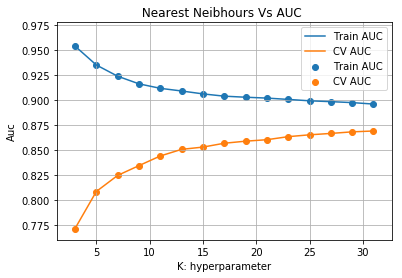

In [246]:
#set7_train_auc,set7_cv_auc
plt.grid()
plt.scatter(neighbors, Set7_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set7_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set7_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set7_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()

AUC for both CrossValidation and Training Data Getting Closer/Converging at Neibhour 29

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 29-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the the Highest accuracy.

Average the accruacis from the Hyper parameters, the value we get is the one we expect on top of test data.


In [247]:
Optimal_N = neighbors[Set7_Cv_Auc.index(max(Set7_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )

Highest nearest neighbors of CrosValidation:  31



According to the CrossValidation, we are getting the Highest Accuacy at Neigherest Neibhour value is at 31.

Hence, we can expext the test data AUC near around the same.

In case we we have the CrossValidation AUC High and Test Accruacy is High, then we can consider it as a Over Fitting.

In case we we have the CrossValidation AUC Low and Test Accruacy is also Low, then we can consider it as a Under Fitting


In [248]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set7_Train_Pred =  knn.predict(X_Bow_Tr)
#Set7_Train_Acc  = accuracy_score(Y_tr,Set7_Train_Pred,normalize=True)

Set7_Train_Auc = []
Set7_Tst_Auc   = []
Set7_Train_Prb = []
Set7_Tst_Prb   = []
Set7_Train_Predict = []
Set7_Tst_Predict   = []


knn =  KNeighborsClassifier(n_neighbors = Optimal_N, leaf_size=30 , algorithm= 'kd_tree')
knn.fit(X_AvgW2V_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_AvgW2V_Tr)
Tst_Predict   =  knn.predict(X_AvgW2V_Test)
        
# Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_AvgW2V_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_AvgW2V_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

#Probablity Scores
Set7_Train_Prb=Train_pred_prob
Set7_Tst_Prb=Tst_pred_prob
    
    #AUC
Set7_Train_Auc=Train_Auc
Set7_Tst_Auc=Test_Auc
    
    #MOdel Predictions    
Set7_Train_Predict=Train_Predict
Set7_Tst_Predict=Tst_Predict
                            
print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is ", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is ", Test_Auc)


 AUC for the  Train Data at nearest neibour  31  is  0.8959334763381663
 AUC for the Test-Validation Data at nearest neibour  31  is  0.8593388415167544


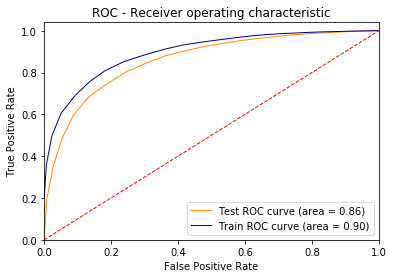

In [249]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set7_tst_fpr, set7_tst_tpr, thresholds = roc_curve(Y_test,Set7_Tst_Prb)
set7_tst_roc_auc = auc(set7_tst_fpr, set7_tst_tpr)


set7_train_fpr, set7_train_tpr, thresholds = roc_curve(Y_tr,Set7_Train_Prb)
set7_train_roc_auc = auc(set7_train_fpr, set7_train_tpr)

lw=1
plt.figure()
plt.plot(set7_tst_fpr, set7_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set7_tst_roc_auc)
plt.plot(set7_train_fpr, set7_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set7_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [250]:
Total_AUC['set7']=[Optimal_N , set7_tst_roc_auc]

###### Confusion Matrix

Train Confusion Matrix::
 [[ 1237  2514]
 [  334 18489]] 



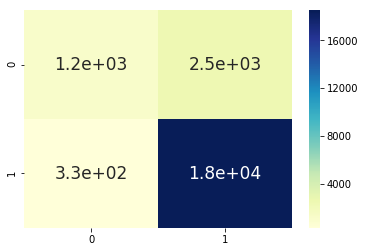

In [251]:
Train_CM= confusion_matrix(Y_tr, Set7_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


Test Confusion Matrix::
 [[  628  1613]
 [  265 11316]] 



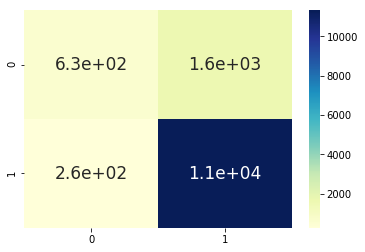

In [252]:
Test_CM= confusion_matrix(Y_test, Set7_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .


Horizantal Lines are Predictions and the Verticals are Acutuals
 

Thus in binary classification, the count of 

true negatives is 628 at C(0,0) , 

false negatives is 265 C(1,0), 

true positives is 11316 at C(1,1) 

and false positives is 1613 at C(0,1).


###### AUC and ROC for Kd-Tree on top Tf-IDF

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 8</font>

In [253]:
#https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/
Set8_Train_Auc = []
Set8_Cv_Auc    = []
for i in neighbors:
    knn =  KNeighborsClassifier(n_neighbors = i, leaf_size=30 , algorithm= 'kd_tree')
    knn.fit(X_AvgW2VtfIdf_Tr,Y_tr)    
    
    #pred_tr =  knn.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    #pred_cv =  knn.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation    
    #Y_train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    #Y_cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation            
    
    #Set8_Acc_Tr.append(Y_train_acc)   #Accuracy                
    #Set8_Acc_Cv.append(Y_cv_acc)      #Accuracy    
     
    
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data    
    Train_pred_prob =  knn.predict_proba(X_AvgW2VtfIdf_Tr)[:,1]    # Probablity of TRAIN-Validation    
    Cv_pred_prob    =  knn.predict_proba(X_AvgW2VtfIdf_Cv)[:,1]    
        
    Train_Auc = roc_auc_score(Y_tr,Train_pred_prob)
    Cv_Auc    = roc_auc_score(Y_cv,Cv_pred_prob)
      
    Set8_Train_Auc.append(Train_Auc)
    Set8_Cv_Auc.append(Cv_Auc)

    print(" AUC for the  TRAIN Data at nearest neibour ",i,  " is ", Train_Auc)
    print(" AUC for the Cross-Validation Data at nearest neibour ",i,  " is ", Cv_Auc)
    

 AUC for the  TRAIN Data at nearest neibour  3  is  0.9153320257880053
 AUC for the Cross-Validation Data at nearest neibour  3  is  0.6593353328173374
 AUC for the  TRAIN Data at nearest neibour  5  is  0.8817401548469471
 AUC for the Cross-Validation Data at nearest neibour  5  is  0.6796473297213622
 AUC for the  TRAIN Data at nearest neibour  7  is  0.8644229785018422
 AUC for the Cross-Validation Data at nearest neibour  7  is  0.6975804566563468
 AUC for the  TRAIN Data at nearest neibour  9  is  0.8509692285142173
 AUC for the Cross-Validation Data at nearest neibour  9  is  0.7080868034055727
 AUC for the  TRAIN Data at nearest neibour  11  is  0.8403287324694076
 AUC for the Cross-Validation Data at nearest neibour  11  is  0.7185769736842106
 AUC for the  TRAIN Data at nearest neibour  13  is  0.8355394236331999
 AUC for the Cross-Validation Data at nearest neibour  13  is  0.7242016640866872
 AUC for the  TRAIN Data at nearest neibour  15  is  0.8303192321605559
 AUC for the

Here, we are trianing the KD-Tree Model with the Avg of Tf-Idf values.

We do not know what is the best nearest neibhour to train the Model.

To find out this, we are trying to train the model on top of Cross-Validation Data with different neighrest neibhours.

We got the AUC, Error and AUC/ROC which helps to judge a Model performance.

Let us see the AUC values for Cross Validation Data and Training Data

#### Plot K-nn Vs AUC

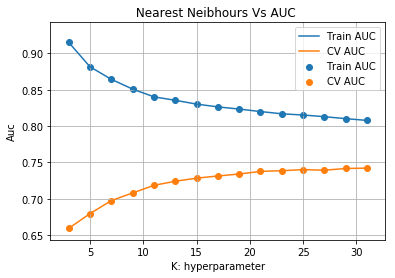

In [254]:

#set8_train_auc,set8_cv_auc
plt.grid()
plt.scatter(neighbors, Set8_Train_Auc, label='Train AUC')
plt.plot(neighbors, Set8_Train_Auc, label='Train AUC')
plt.scatter(neighbors, Set8_Cv_Auc, label='CV AUC')
plt.plot(neighbors, Set8_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Auc")
plt.title(" Nearest Neibhours Vs AUC  ")
plt.show()



Both AUC for CrossValidation and Training Data Getting Closer/Converging at Neibhour 31

Accoring to analysis of Train-AUC and CrosValidation-AUC,we can Uderstand that 31-nearest neibhours will be the best fit.

Let us figure out, which hyper parameter can yeild the the Highest accuracy.

Average the accruacis from the Hyper parameters, the value we get is the one we expect on top of test data.


In [255]:
Optimal_N = neighbors[Set8_Cv_Auc.index(max(Set8_Cv_Auc))]  
print("Highest nearest neighbors of CrosValidation: ", Optimal_N  )

Highest nearest neighbors of CrosValidation:  31


According to the CrossValidation, we are getting the Highest auc at Neigherest Neibhour value is at 31.

Hence, we can expext the test data AUC near around the same.

In case we we have the CrossValidation AUC High and Test Accruacy is High, then we can consider it as a Over Fitting.

In case we we have the CrossValidation AUC Low and Test Accruacy is also Low, then we can consider it as a Under Fitting


In [256]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#Set8_Train_Pred =  knn.predict(X_Bow_Tr)
#Set8_Train_Acc  = accuracy_score(Y_tr,Set8_Train_Pred,normalize=True)

Set8_Train_Auc = []
Set8_Tst_Auc   = []
Set8_Train_Prb = []
Set8_Tst_Prb   = []
Set8_Train_Predict = []
Set8_Tst_Predict   = []

knn =  KNeighborsClassifier(n_neighbors = i, leaf_size=30 , algorithm= 'kd_tree')
knn.fit(X_AvgW2VtfIdf_Tr,Y_tr)    
    
Train_Predict =  knn.predict(X_AvgW2VtfIdf_Tr)
Tst_Predict   =  knn.predict(X_AvgW2VtfIdf_Test)
        
    # Let PLOT  AUC-socre Vs each nearest neibhours  for both Test and CrossValidation Data
Train_pred_prob   =  knn.predict_proba(X_AvgW2VtfIdf_Tr)[:,1] # Probablity of TRAIN-Validation 
Tst_pred_prob     =  knn.predict_proba(X_AvgW2VtfIdf_Test)[:,1] 

Train_Auc=  roc_auc_score(Y_tr,Train_pred_prob)
Test_Auc  = roc_auc_score(Y_test,Tst_pred_prob)

    #Probablity Scores
Set8_Train_Prb=Train_pred_prob
Set8_Tst_Prb=Tst_pred_prob
    
    #AUC
Set8_Train_Auc=Train_Auc
Set8_Tst_Auc=Test_Auc
    
    #MOdel Predictions    
Set8_Train_Predict=Train_Predict
Set8_Tst_Predict=Tst_Predict

print(" AUC for the  Train Data at nearest neibour ",Optimal_N,  " is ", Train_Auc)
print(" AUC for the Test-Validation Data at nearest neibour ",Optimal_N,  " is ", Test_Auc)

 AUC for the  Train Data at nearest neibour  31  is  0.8078603502045809
 AUC for the Test-Validation Data at nearest neibour  31  is  0.7389905783993316


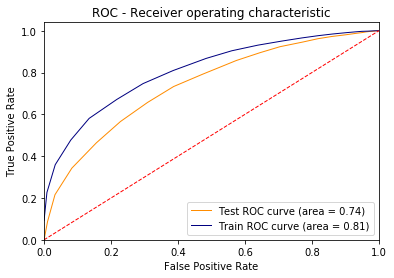

In [257]:

#https://qiita.com/bmj0114/items/460424c110a8ce22d945
set8_tst_fpr, set8_tst_tpr, thresholds = roc_curve(Y_test,Tst_pred_prob)
set8_tst_roc_auc = auc(set8_tst_fpr, set8_tst_tpr)


set8_train_fpr, set8_train_tpr, thresholds = roc_curve(Y_tr,Train_pred_prob)
set8_train_roc_auc = auc(set8_train_fpr, set8_train_tpr)

lw=1
plt.figure()
plt.plot(set8_tst_fpr, set8_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set8_tst_roc_auc)
plt.plot(set8_train_fpr, set8_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set8_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [258]:
Total_AUC['set8']=[Optimal_N , set8_tst_roc_auc]

###### Confusion Matrix

Train Confusion Matrix::
 [[  363  3388]
 [  173 18650]] 



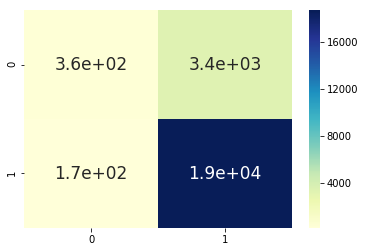

In [259]:
Train_CM= confusion_matrix(Y_tr, Set8_Train_Predict, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n",Train_CM,"\n")
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})

Test Confusion Matrix::
 [[  155  2086]
 [  148 11433]] 



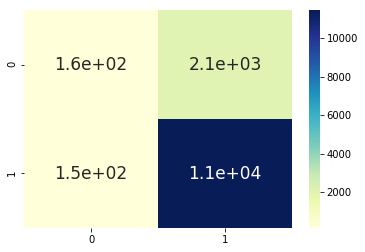

In [260]:
Test_CM= confusion_matrix(Y_test, Set8_Tst_Predict, labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n",Test_CM,"\n")  
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .

Horizantal Lines are Predictions and the Verticals are Acutuals

Thus in binary classification, the count of true 

negatives is 154 at C(0,0) , 

false negatives is 148 C(1,0),

true positives is 11433 at C(1,1),

false positives is 2086 at C(0,1).


# [6] Conclusions

In [261]:
#Letus check all the neibours
from prettytable import PrettyTable

In [262]:
#http://zetcode.com/python/prettytable/
x = PrettyTable()
x.clear_rows()
sets = ["BOW","TFIDF","W2V","TFIDFW2V"]
x.field_names = ["SET","Vectorizer", "Model", "Best Hyper parameter", "Test AUC"]
for i,j in enumerate(Total_AUC) :    
    #print(j,sets[(i%4)],"Brute",Total_ACU[j][0],Total_ACU[j][1])
    x.add_row([ j, sets[(i%4)], ("Brute") if (i < 3) else ("KD-Tree") ,Total_AUC[j][0],Total_AUC[j][1]])
print(x)

+------+------------+---------+----------------------+--------------------+
| SET  | Vectorizer |  Model  | Best Hyper parameter |      Test AUC      |
+------+------------+---------+----------------------+--------------------+
| set1 |    BOW     |  Brute  |          31          | 0.7490356132336193 |
| set2 |   TFIDF    |  Brute  |          31          | 0.7525841018662144 |
| set3 |    W2V     |  Brute  |          31          | 0.8591701520990562 |
| set4 |  TFIDFW2V  | KD-Tree |          31          | 0.5280130586724374 |
| set5 |    BOW     | KD-Tree |          31          | 0.745163983029182  |
| set6 |   TFIDF    | KD-Tree |          31          | 0.7518026128827161 |
| set7 |    W2V     | KD-Tree |          31          | 0.8593388415167544 |
| set8 |  TFIDFW2V  | KD-Tree |          31          | 0.7389905783993316 |
+------+------------+---------+----------------------+--------------------+


Area Under the Curve is the best Metrice to understand or to compare the Models.

In the Above table, we can see each model with its Hyper parameter and corresponding the Test AUC.

By Observing the above Auc fOR each Model we can conclude Highest Test Area under the curve is 0.8593388415167544.

And we are acheiving the High AUC with AVg Tf-idf for KD-Tree Algorithms.